# SEIR-HCD Model
* By Daniel Traian Pele

This is a working example of a [SIER](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model) model with added compartments for HCD. The letters stand for:
* Susceptible
* Exposed
* Infected
* Recovered
* Hospitalized
* Critical
* Death

Acknowledgments:
* https://www.kaggle.com/anjum48/seir-hcd-model
* http://gabgoh.github.io/COVID/index.html
* https://neherlab.org/covid19



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

## The parameters used in the model are taken from the following studies:
* Coronavirus disease 2019 (COVID-19) in the EU/EEA and the UK – eighth update - 8 April 2020, 
https://www.ecdc.europa.eu/sites/default/files/documents/
    covid-19-rapid-risk-assessment-coronavirus-disease-2019-eighth-update-8-april-2020.pdf
* Chang D, Mo G, Yuan X et al. Am J Resp Crit Care Med 2020. doi: 10.1164/rccm.202003-0524LE

## Parameters used in the model

`R_t` = reproduction number at time t. We use 2.79 at t=0.

**Transition times**
* `T_inc` = average incubation period.  We use 5 days.
* `T_inf` = average infectious period. We use 8 days.
* `T_hosp` = average time a patient is in hospital before either recovering or becoming critical. We use 4 days.
* `T_crit` = average time a patient is in a critical state (either recover or die). We use 14 days.

**Fractions**
:
* `m_a` = fraction of infections that are asymptomatic or mild.  We use 68%.
* `c_a` = fraction of severe cases that turn critical.  We use 0.77%.
* `f_a` = fraction of critical cases that are fatal.  We use  11%.



In [11]:
# Susceptible equation
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Exposed equation
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)


# Infected equation
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)


# Hospialized equation
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical equation
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered equation
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths equation
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit


def SEIR_HCD_model(t, y, R_t, t_inc=5, t_inf=8, t_hosp=4, t_crit=14, m_a=0.68, c_a=0.0077, f_a=0.11):
    """

    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Reproduction number
    :param t_inc: Average incubation period. Default 5 days
    :param t_inf: Average infectious period. Default 8 days
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    :param t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    :param m_a: Fraction of infections that are asymptomatic or mild. Default 0.68
    :param c_a: Fraction of severe cases that turn critical. Default 0.077
    :param f_a: Fraction of critical cases that are fatal. Default 0.11
    :return:
    """
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, E, I, R, H, C, D = y
    
    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

# Fitting the model to data
There are certain variables that we can play with to fit the model to real data:
* Average incubation period, `t_inc`
* Average infection period, `t_inf`
* Average hospitalization period, `t_hosp`
* Average critital period, `t_crit`
* The fraction of mild/asymptomatic cases, `m_a`
* The fraction of severe cases that turn critical, `c_a`
* The fraction of critical cases that result in a fatality, `f_a`
* Reproduction number, `R_0` or `R_t`

The some of these are likely to be constants specific to the virus and some are likely to be time dependent variables dependent on factors such as:
* When a government intervened
* Peoples behaviours (do people actively self-isolate, not visit religious shrines etc.)
* Population demographic of a country (is a significant proportion of the population old?). This is the `a` subscript
* Heathcare system capacity (hostpital beds per capita)
* Number of testing kits available

We have already used two different reproduction numbers above. Let's see if we can derive a time-dependent `R_t` from the data. We will also try and optimize a handful of the parameters above to match the data.

We will also compare this to just using a single reproduction number. This might actaully be more suitable in countries where the outbreak has just started or they are struggling to limit the spread.

There are lots of ways to decay a parameter in epidemiology. I'm going to use a Hill decay, which has 2 parameters, `k` and `L` (the half decay constant):

In [12]:
DATE_BORDER = '2020-04-08'

data_path = Path('D:/Python/Covid-19 Forecasting/Romania/mai/')


train = pd.read_csv(data_path / 'train.csv', parse_dates=['Date'])
test = pd.read_csv(data_path /'test.csv', parse_dates=['Date'])
train.dropna()
population=19237691

# Remove the leaking data
train_full = train.copy()
valid = train[train['Date'] >= test['Date'].min()]
train = train[train['Date'] < test['Date'].min()]

# Split the test into public & private
test_public = test[test['Date'] <= DATE_BORDER]
test_private = test[test['Date'] > DATE_BORDER]

# Use a multi-index for easier slicing
train_full.set_index([ 'Date'], inplace=True)
train.set_index(['Date'], inplace=True)
valid.set_index(['Date'], inplace=True)
test_public.set_index([ 'Date'], inplace=True)
test_private.set_index([ 'Date'], inplace=True)


train_full.shape, train.shape, valid.shape, test_public.shape, test_private.shape

((43, 7), (29, 7), (13, 7), (14, 7), (29, 7))

The function below evaluates a model with a constant `R` number as well as `t_hosp`, `t_crit`, `m`, `c`, `f`

In [13]:
OPTIM_DAYS = 14 # Number of days to use for the optimisation evaluation

In [14]:
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, t_hosp, t_crit, m, c, f = params
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (R_0, 5.6, 2.9, t_hosp, t_crit, m, c, f)
               
    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['ConfirmedCases'].values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

The function below is essentially the same as above, by R is decayed using a Hill decay function. This model requires 2 additional parameters to be optimized, `k` & `L`

In [15]:
# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, t_hosp, t_crit, m, c, f, k, L = params  
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    
    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)
    
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (time_varying_reproduction, 5.6, 2.9, t_hosp, t_crit, m, c, f)
            
    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['ConfirmedCases'].values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [16]:
def use_last_value(train_data, valid_data, test_data):
    lv = train_data[['ConfirmedCases', 'Fatalities']].iloc[-1].values
    
    if valid_data is not None:
        y_pred_valid = np.ones((len(valid_data), 2)) * lv.reshape(1, 2)
        y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]

        msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid[:, 0])
        msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid[:, 1])
        msle_final = np.mean([msle_cases, msle_fat])

        return msle_final

In [17]:
def plot_model_results(y_pred, train_data, valid_data=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    
    ax1.set_title('Romania Confirmed Cases')

    ax1.set_ylabel('Confirmed Cases',fontsize=10)
    ax2.set_title('Romania Fatalities')
    
    ax2.set_ylabel('Deaths',fontsize=10)
    train_data['ConfirmedCases'].plot(label='Historical', color='blue', ax=ax1)
    #y_pred.loc[train_data.index, 'ConfirmedCases'].plot(label='Predictive', color='red',linestyle='--', ax=ax1)
    #ax3 = y_pred['R'].plot(label='Reproduction number', color='c', linestyle='-', secondary_y=True, ax=ax1)
    #ax3.set_ylabel("Reproduction number", fontsize=10, color='c');
        
    train_data['Fatalities'].plot(label='Fatalities (train)', color='blue', ax=ax2)
    y_pred.loc[train_data.index, 'Fatalities'].plot(label='Fatalities', color='blue', ax=ax2)
    
    if valid_data is not None:
        valid_data['ConfirmedCases'].plot(label='Confirmed Cases (valid)', color='blue', linestyle=':', ax=ax1)
        valid_data['Fatalities'].plot(label='Fatalities (valid)', color='blue', linestyle=':', ax=ax2)
        y_pred.loc[valid_data.index, 'ConfirmedCases'].plot(label='Modeled Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[valid_data.index, 'Fatalities'].plot(label='Predictive)', color='r', linestyle='--', ax=ax2)
    else:
        y_pred.loc[:, 'ConfirmedCases'].plot(label='Predictive', color='r', linestyle='--', ax=ax1)
        y_pred.loc[:, 'Fatalities'].plot(label='Predictive', color='r', linestyle='--', ax=ax2)
        
    ax1.legend(loc='best')
    

The function below fits a SEIR-HCD model for each area, either using a constant R or a decayed R, whichever is better. If the total cases/1M pop is below 1, then the last value is used.

In [18]:
def fit_model_validation(
                     initial_guess=[4, 4, 14,  0.67, 0.0077, 0.11, 2, 50],
                     bounds=((1, 20), # R bounds
                             (0.5, 10), (2, 20), # transition time param bounds
                             (0.5, 1), (0, 1), (0, 1), (1, 5), (1, 100)), # fraction time param bounds
                     make_plot=True):
        
    train_data = train.query('ConfirmedCases > 0')
    valid_data = valid
    test_data = test_public
    

        
    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
        
    if cases_per_million < 1:
        return use_last_value(train_data, valid_data, test_data)
                
    res_const = minimize(eval_model_const, initial_guess[:-2], bounds=bounds[:-2],
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    dates_all = train_data.index.append(test_data.index)
    dates_val = train_data.index.append(valid_data.index)
    
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_val), dates_val)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_val))
        R_0, t_hosp, t_crit, m, c, f, k, L = res.x  
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_val)
        
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population,
        'Fatalities': np.clip(deaths, 0, np.inf) * population,
        'R': R_t,
    }, index=dates_all)
    
    y_pred_valid = y_pred.iloc[len(train_data): len(train_data)+len(valid_data)]
    y_pred_test = y_pred.iloc[len(train_data):]
    y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]
        
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    if make_plot:
        print(f'Validation MSLE: {valid_msle:0.5f}')
        print(f'R: {res.x[0]:0.3f}, t_hosp: {res.x[1]:0.3f}, t_crit: {res.x[2]:0.3f}, '
              f'm: {res.x[3]:0.3f}, c: {res.x[4]:0.3f}, f: {res.x[5]:0.3f}')
        plot_model_results(y_pred, train_data, valid_data)
        
   
    return valid_msle

In [24]:
# Fit a model on the full dataset (i.e. no validation)
def fit_model_full(
                      initial_guess=[2.79, 4, 14, 0.67, 0.0077, 0.11, 2, 60],
                      bounds=((1, 20), # R bounds
                              (0.5, 10), (2, 20), # transition time param bounds
                              (0.5, 1), (0, 0.8), (0, 0.8), (1, 5), (1, 100)), # fraction time param bounds
                      make_plot=True):
        
    train_data = train_full.query('ConfirmedCases > 0')
    test_data = test_private
    

    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
        
    if cases_per_million < 1:
        return use_last_value(train_data, None, test_data)
                
    res_const = minimize(eval_model_const, initial_guess[:-2], bounds=bounds[:-2],
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    dates_all = train_data.index.append(test_data.index)
    
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_all), dates_all)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_all))
        R_0, t_hosp, t_crit, m, c, f, k, L = res.x  
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_all)
        
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population,
        'Fatalities': np.clip(deaths, 0, np.inf) * population,
        'R': R_t,
    }, index=dates_all)
    
    y_pred_test = y_pred.iloc[len(train_data):]
    
    if make_plot:
        print(f'R: {res.x[0]:0.3f}, t_hosp: {res.x[1]:0.3f}, t_crit: {res.x[2]:0.3f}, '
              f'm: {res.x[3]:0.3f}, c: {res.x[4]:0.3f}, f: {res.x[5]:0.3f}')
        plot_model_results(y_pred, train_data)
    y_pred=pd.DataFrame(y_pred)
    y_pred.to_csv('D:/Python/Covid-19 Forecasting/Romania/seir.csv',\
                                                  index=False)


Validation MSLE: 0.30776
R: 4.351, t_hosp: 10.000, t_crit: 19.801, m: 0.504, c: 1.000, f: 0.420


0.30776355500369273

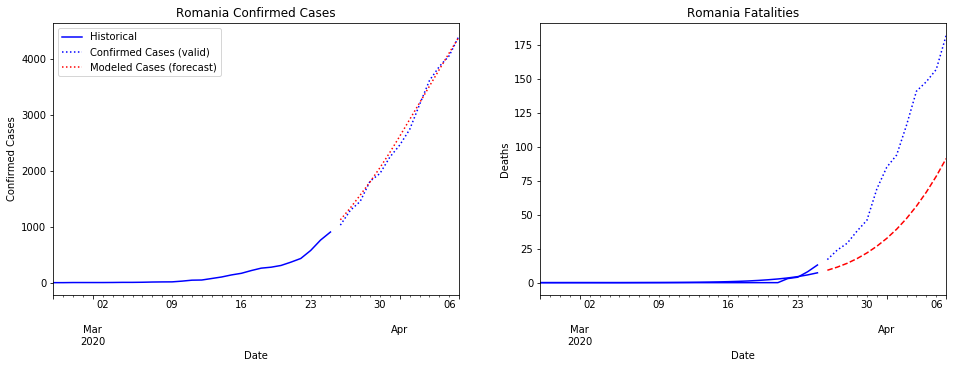

In [20]:
fit_model_validation()


R: 4.338, t_hosp: 0.525, t_crit: 9.697, m: 0.515, c: 0.800, f: 0.242


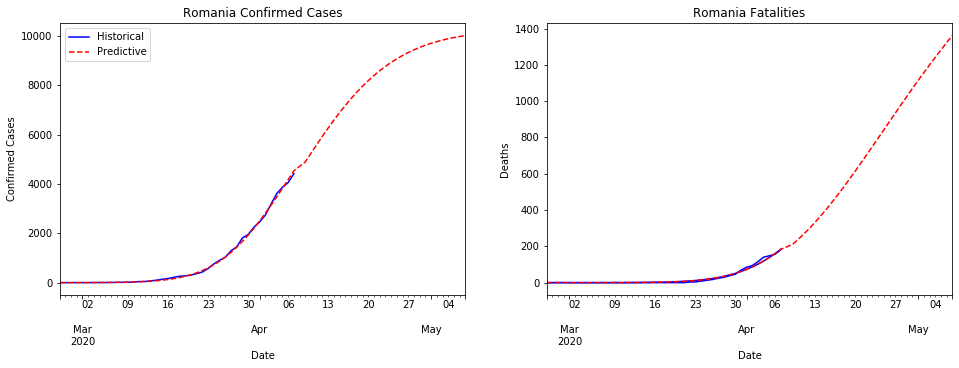

In [25]:
fit_model_full()